In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import copy  

In [32]:
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [33]:
def prepare_data():
    # Преобразования для изображений
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    
    bicycle_idx = trainset.class_to_idx['bicycle']
    motorcycle_idx = trainset.class_to_idx['motorcycle']
    
    # Фильтрую данные, оставляя только нужные классы
    # 0 - background (10% от остальных классов)
    # 1 - bicycle
    # 2 - motorcycle
    train_data = []
    train_labels = []
    for img, label in trainset:
        if label == bicycle_idx:
            train_data.append(img)
            train_labels.append(1)
        elif label == motorcycle_idx:
            train_data.append(img)
            train_labels.append(2)
        else:
            if np.random.random() < 0.1: # Беру только 10% фоновых изображений
                train_data.append(img)
                train_labels.append(0)
    
    # То же самое для тестового набора
    test_data = []
    test_labels = []
    for img, label in testset:
        if label == bicycle_idx:
            test_data.append(img)
            test_labels.append(1)
        elif label == motorcycle_idx:
            test_data.append(img)
            test_labels.append(2)
        else:
            if np.random.random() < 0.1:
                test_data.append(img)
                test_labels.append(0)
    
    train_dataset = torch.utils.data.TensorDataset(torch.stack(train_data), 
                                                 torch.tensor(train_labels))
    test_dataset = torch.utils.data.TensorDataset(torch.stack(test_data), 
                                                torch.tensor(test_labels))
    
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False, num_workers=2)
    
    return trainloader, testloader


In [34]:
def get_model():
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    
    # Замораживаю все слои  
    for param in model.parameters():
        param.requires_grad = False

    # Заменяю последний слой на новый 
    model.fc = nn.Linear(model.fc.in_features, 3)
    
    return model.to(DEVICE)


In [35]:
def train_model(model, trainloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.3f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return running_loss/len(trainloader), 100.*correct/total


In [36]:
# Оценка модели на тестовом наборе
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return 100.*correct/total, all_preds, all_targets


In [37]:
def convert_model_to_grayscale(model):
    grayscale_model = copy.deepcopy(model)
    
    # Получаем веса первого сверточного слоя
    conv1_weights = grayscale_model.conv1.weight.data
    
    # Правильное усреднение весов RGB каналов
    grayscale_weights = conv1_weights.sum(dim=1, keepdim=True) / 3.0
    
    # Создаем новый сверточный слой для grayscale входа
    new_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    new_conv1.weight.data = grayscale_weights
    
    grayscale_model.conv1 = new_conv1
    return grayscale_model.to(DEVICE)


Files already downloaded and verified
Files already downloaded and verified
Phase 1: Training only classifier
Epoch: 0, Batch: 0, Loss: 0.974, Acc: 57.81%
Epoch: 0, Batch: 50, Loss: 0.486, Acc: 80.24%
Epoch 1: Train Loss: 0.609, Train Acc: 81.84%, Test Acc: 82.52%
Epoch: 1, Batch: 0, Loss: 0.686, Acc: 76.56%
Epoch: 1, Batch: 50, Loss: 0.514, Acc: 84.07%
Epoch 2: Train Loss: 0.496, Train Acc: 83.30%, Test Acc: 82.78%
Epoch: 2, Batch: 0, Loss: 0.284, Acc: 93.75%
Epoch: 2, Batch: 50, Loss: 0.297, Acc: 83.21%
Epoch 3: Train Loss: 0.426, Train Acc: 83.81%, Test Acc: 83.48%

Phase 2: Fine-tuning last block
Epoch: 0, Batch: 0, Loss: 0.345, Acc: 84.38%
Epoch: 0, Batch: 50, Loss: 0.232, Acc: 89.95%
Epoch 1: Train Loss: 0.244, Train Acc: 91.77%, Test Acc: 95.89%
Epoch: 1, Batch: 0, Loss: 0.086, Acc: 100.00%
Epoch: 1, Batch: 50, Loss: 0.105, Acc: 96.32%
Epoch 2: Train Loss: 0.122, Train Acc: 96.46%, Test Acc: 96.85%
Epoch: 2, Batch: 0, Loss: 0.055, Acc: 98.44%
Epoch: 2, Batch: 50, Loss: 0.055, Ac

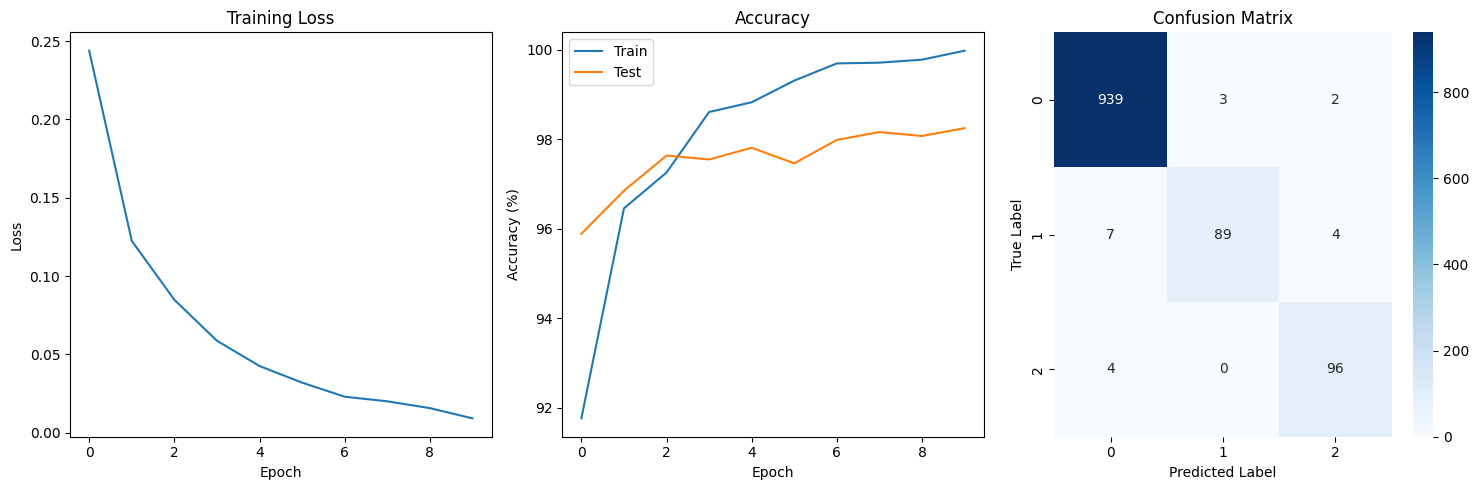


Classification Report:
              precision    recall  f1-score   support

  Background       0.99      0.99      0.99       944
     Bicycle       0.97      0.89      0.93       100
  Motorcycle       0.94      0.96      0.95       100

    accuracy                           0.98      1144
   macro avg       0.97      0.95      0.96      1144
weighted avg       0.98      0.98      0.98      1144


Testing on grayscale images
Files already downloaded and verified
Accuracy on grayscale images: 88.98%


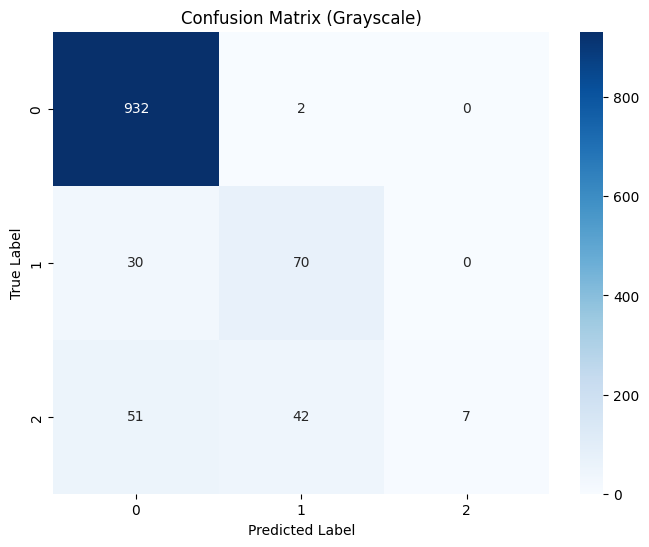


Classification Report (Grayscale):
              precision    recall  f1-score   support

  Background       0.92      1.00      0.96       934
     Bicycle       0.61      0.70      0.65       100
  Motorcycle       1.00      0.07      0.13       100

    accuracy                           0.89      1134
   macro avg       0.84      0.59      0.58      1134
weighted avg       0.90      0.89      0.86      1134



In [38]:
def main():
    trainloader, testloader = prepare_data()
    model = get_model()
    criterion = nn.CrossEntropyLoss()
    
    # Фаза 1: обучаем только классификатор (3 эпохи)
    print("Phase 1: Training only classifier")
    optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(3):
        train_loss, train_acc = train_model(model, trainloader, criterion, optimizer, epoch)
        test_acc, _, _ = evaluate_model(model, testloader)
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    # Фаза 2: размораживаем последний блок и дообучаем (10 эпох)
    print("\nPhase 2: Fine-tuning last block")
    for param in model.layer4.parameters():
        param.requires_grad = True
    
    optimizer = optim.Adam([
        {'params': model.fc.parameters()},
        {'params': model.layer4.parameters(), 'lr': LEARNING_RATE/10}
    ], lr=LEARNING_RATE)
    
    train_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_model(model, trainloader, criterion, optimizer, epoch)
        test_acc, preds, targets = evaluate_model(model, testloader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, '
              f'Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    # Анализ 
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(test_accs, label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print('\nClassification Report:')
    print(classification_report(targets, preds, 
                              target_names=['Background', 'Bicycle', 'Motorcycle']))
    
    # Тестирование на grayscale изображениях
    print("\nTesting on grayscale images")
    grayscale_model = convert_model_to_grayscale(model)
    
    # Обновленный transform для grayscale
    grayscale_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.449], std=[0.226])
    ])
    
    # Создаем новый тестовый набор данных
    testset_gray = torchvision.datasets.CIFAR100(root='./data', train=False,
                                                download=True, transform=grayscale_transform)
    
    # Фильтруем только нужные классы
    bicycle_idx = testset_gray.class_to_idx['bicycle']
    motorcycle_idx = testset_gray.class_to_idx['motorcycle']
    
    test_data = []
    test_labels = []
    for img, label in testset_gray:
        if label == bicycle_idx:
            test_data.append(img)
            test_labels.append(1)
        elif label == motorcycle_idx:
            test_data.append(img)
            test_labels.append(2)
        else:
            if np.random.random() < 0.1:
                test_data.append(img)
                test_labels.append(0)
    
    test_dataset = torch.utils.data.TensorDataset(torch.stack(test_data), 
                                                torch.tensor(test_labels))
    testloader_gray = torch.utils.data.DataLoader(test_dataset, 
                                                batch_size=BATCH_SIZE,
                                                shuffle=False, 
                                                num_workers=2)
    
    # Оцениваем производительность на grayscale изображениях
    gray_acc, gray_preds, gray_targets = evaluate_model(grayscale_model, testloader_gray)
    print(f'Accuracy on grayscale images: {gray_acc:.2f}%')
    
    # Выводим confusion matrix для grayscale результатов
    plt.figure(figsize=(8, 6))
    cm_gray = confusion_matrix(gray_targets, gray_preds)
    sns.heatmap(cm_gray, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Grayscale)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print('\nClassification Report (Grayscale):')
    print(classification_report(gray_targets, gray_preds, 
                              target_names=['Background', 'Bicycle', 'Motorcycle']))

if __name__ == '__main__':
    main()